# ART RECOMMENDER SYSTEM

## Analysing Data - MET

This script will take the data retrieved from step [Importing and Cleaning Data - MET](01_MET_LoadClean.ipynb) and perform several analysis: TFIDF Analysis, StopWord removal, Topic Analysis and Topic graph.  

The best fitting topic model will be saved to use in further steps to try and match the resulting topics with the topics found in the [Data Analysis for Prado](04_Prado_AnalysisTFIDF.ipynb)

In [1]:
import pickle
import nltk
import pandas as pd
import numpy as np

from sklearn import decomposition
from sklearn import feature_extraction
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import TfidfVectorizer


**Load all the descriptions retrieved from the scrapping of the website**

In [4]:
mypath = '../MetFiles/'
onlyfiles = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
len(onlyfiles)

35

In [25]:
met_df = []
for p in onlyfiles[2:] :
    with open(mypath + p, 'rb') as f:
        met_df = met_df + pickle.load(f)
met_df = pd.DataFrame(met_df, columns=['link', 'descripcion', 'ent'])
met_df.tail()

,link,descripcion,ent
75450,http://www.metmuseum.org/art/collection/search...,This portrait of Samuel Verplanck (1739–1820) ...,None
75451,http://www.metmuseum.org/art/collection/search...,"As an ambitious young painter in the colonies,...",None
75452,http://www.metmuseum.org/art/collection/search...,Although the attribution of this iconic work t...,None
75453,http://www.metmuseum.org/art/collection/search...,Couse may have first developed an interest in ...,None
75454,http://www.metmuseum.org/art/collection/search...,Anne Goldthwaite (1869-1944) was an artist and...,None


**Remove duplicates and noisy data**

In [26]:
#Eliminar duplicados
print(len(met_df))
met_df=met_df.drop_duplicates('descripcion')
print(len(met_df))

75455
41539


In [27]:
#Eliminar los vacios y el beisbol!!
print(len(met_df))
met_df=met_df[(met_df['descripcion'] != '') ] # & (met_df['descripcion'].str.contains("card") == False)]
total=len(met_df)
print(total)

41539
41538


In [28]:
met_df.reset_index(inplace=True)
met_df.tail()

,index,link,descripcion,ent
41533,75450,http://www.metmuseum.org/art/collection/search...,This portrait of Samuel Verplanck (1739–1820) ...,None
41534,75451,http://www.metmuseum.org/art/collection/search...,"As an ambitious young painter in the colonies,...",None
41535,75452,http://www.metmuseum.org/art/collection/search...,Although the attribution of this iconic work t...,None
41536,75453,http://www.metmuseum.org/art/collection/search...,Couse may have first developed an interest in ...,None
41537,75454,http://www.metmuseum.org/art/collection/search...,Anne Goldthwaite (1869-1944) was an artist and...,None


# TFIDF Analysis

**Stop Words**  
(Stop words in spanish were downloaded from [here](https://github.com/stopwords-iso))

In [29]:
from nltk.corpus import stopwords

#Spanish
with open('../utils/stopwords-es.txt') as f:
    stop_words_es = f.readlines()
stop_words_es = [sw.replace('\n', '') for sw in stop_words_es]
stop_words_es += 'a b c d e f g h i j k l m n ñ o p q r s t u v w x y z'.split()
stop_words_es += 'i ii iii iv v vi vii viii ix x xi xii xiii xiv xv xvi xvii xviii xix xx pp'.split()
stop_words_es += 'first second third fourth fifth sixth seventh eigth ninth tenth twelfth sixteenth seventeenth eighteenth nineteenth twenty twientieth'.split()
stop_words_es += 'january february march april may june july august september october november december'.split()

##English
stop_words_en = stopwords.words('english')
stop_words_en = stop_words_en + stop_words_es 
stop_words_en += 'one two three four five six seven eight nine ten'.split()
stop_words_en += 'museum museums met work works painting paintings artist artists drawing drawings canvas art arts \
                painter painters century centuries period periods decade decades picture pictures since life lives \
                architecture architecturally project projects common throughout full across however popular name names ca mid tip \
                aspect aspects image images imagery various known technique techniques scene scenes time times \
                develop develops developed depeloping theme themes topic topics overall show showed shows showing shown important \
                commission commissioned commissioning commissions treatment serie series notebook notebooks tone tones \
                left right top bottom up upper down front behind back high highly higher low lower \
                group around among surrounded half middle inside outside along \
                typical state states rare identity identities slight slightly self type types additional version \
                year years catalog catalogs exposition expositions similar idea ideas author authors element elements \
                master masters academy academies character characters inferior superior effect effects color colors \
                model models evident relation relations relate related relates relationship relationships bound \
                characteristic characteristics characterized format formats copy copies note notes noted noting \
                charge charges intended active actives part parts apart proofs site sites event events region regions \
                which inventory inventories position positions positioned positioning text texts relief form forms \
                big large small short short great thin wide widely thick narrow stretch round deep underneath \
                profile profiles these another other feature features still instead near far detail details sort sorts \
                could together rather surface surfaces traditional shape shapes shaped object objects even mayor minor \
                line lines fine past future impression impressions photo photos famous copyright motif motifs \
                vivacity worth thematic spontaneity spontaneous surprisingly little movement movements \
                typography portfolio portfolios \
                including included includes include create created creates creating composition subject subjects \
                express expressed expresses expressing expression appear appears appeared appearing piece pieces \
                producing produced produces produce product production probably long set sets example examples \
                publish publishes published publishing public de des study studio studies semi also within much \
                portrait portraits page pages source sources interesting uninteresting constrained edition editions \
                et co cm center central side sides issue well collection collections many few several style styles \
                often among although around would different school schools date dates dated base bases based \
                pictoric pattern patterns ocassion ocassions almost without upon either whose perhaps new \
                angle angles case cases some difference differences icon icons iconography interior exterior \
                especial especially sure surely possible possibly particular particularly original originally \
                content contents early earlier late later title titles titled like likely seem seemingly \
                pose poses posed posing usually usual unusually unusual area areas sheet sheets paper papers volume volumes \
                attribution attributed attribute attributes attributing print printed prints printing \
                contain contains contained containing content paint paints painted find found finds finding \
                design designs designed designing designer designers figure figures figured figuring \
                create creates created creating associate associates associated associating likelihood \
                issue issues issued issuing horizontal vertical border borders flanked variety varieties \
                extract extracts extracted extracting give gave gives giving end ends ended ending cut cuts cutting \
                represent represented represents representing present presented presents presenting commemorative \
                finish finished finishes finishing sustain sustained sustains sustaining hold held holds holding \
                allow allowed allowes allowing remember remembered remembers remembering begin began begins beginning \
                inscribe inscribed inscribes inscribing cover covered covers covering make made makes making \
                place placed places placing worked working became becomes becomming put puts putting \
                admire admired admires admiring donated donation donate donating use uses used using \
                adapt adapted adapts adapting call called calls calling see saw sees seem seen seeing \
                compose composed composes composing suggest suggested suggests suggesting suggestion suggestions \
                depict depicts depicted depicting distribute distributes distributed distributing \
                inspire inspires inspired inspiring elaborate elaborates elaborated elaborating elaborately \
                view viewed views viewing execute executes executed executing write wrote writes written writing \
                render rendered renders rendering process processed processes processing match matches matched matching \
                demonstrate demonstrates demostrated demosntrating derive derives derived deriving remain remains remained remaining \
                reveal reveals revealed revealing replace replacing replaced replaces abstract abstracted abstracts abstracting \
                decorate decorates decorated decorating decoration register registers registered registering exhibit exhibits exhibited exhibiting \
                size sized sizes sizing insert inserts inserted inserting promote promotes promoted promoting \
                label labels labeled labeling comprise comprises comprised comprising limit limited limits limiting \
                etch etches etched etching belong belonged belongs belonging grant granted grants granting \
                spend spends spent spending consist consisted consists consisting alternate alternated alternates alternating \
                republish republishes republished republishing dispense dispensed dispenses dispensing supply supplies supplied supplying \
                last lasted lasts lasting pursue pursued pursues pursuing introduce introduces introduced introducing \
                balance balances balanced continue continued continues continuing purchase purchases purchased purchasing \
                chose choses chosed chosing chosen live lives lived living combine combined combines combining \
                turn turns turned turning add adds added adding reach reaches reached reaching draw drawn drew drawing \
                look looks looked looking bring brang brings bringing incorporate incorporates incorporated incorporating \
                indicate indicates indicated indicating come came comes coming describe describes described describing \
                prevail prevailed prevails prevailing understand understands understood understanding understandings \
                demonstrate demonstrates demonstrated demonstrating break breakes broke breaking took takes take taking \
                carve carved carves carving'.split()
stop_words_en = set(stop_words_en)

**TFIDF Model**

In [30]:
idf_vectorizer = feature_extraction.text.TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words=stop_words_en,
    token_pattern="\\b[a-z][a-z]+\\b",
    min_df=0.001,
    max_df=0.2
)
counts = idf_vectorizer.fit_transform(met_df['descripcion'])

In [31]:
feature_names = idf_vectorizer.get_feature_names()
print(f"""
number of features: {len(feature_names):,}
random set of features: {np.random.choice(feature_names, size=20)}
""")


number of features: 7,385
random set of features: ['cassidy bread' 'results' 'floral' 'etcher successful' 'predella' 'apron'
 'academic' 'yellow orange' 'macmillan' 'swords' 'wider' 'flask' 'mary'
 'rings' 'inn' 'archaic' 'bows' 'scholarly' 'ribbed' 'scepter']



In [32]:
# Create the term-document matrix
counts = idf_vectorizer.transform(met_df['descripcion'])
# Esto me da TODOS los documentos con el TDIDF por PALABRA
counts.shape

(41538, 7385)

## Topic Analysis NMF

**How many topics?**  
Check inertia value from K-means models using diffferent k values.  KMeans is not the best model in this case, but it will give us an idea for k (Number of topics) when inertia is the lowest

In [62]:
from sklearn.cluster import KMeans

x = range(24,40)
y_inertia = []

for k in x:
    km = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=1, n_jobs=1, max_iter=3)
    km.fit(counts)
    labels = km.labels_
    y_inertia.append(km.inertia_)
    print(k)

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0,0.5,'Inertia')

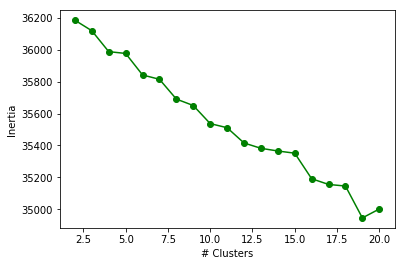

In [16]:
%pylab inline
plt.plot(x, y_inertia, 'go-', )
plt.xlabel('# Clusters')
plt.ylabel('Inertia')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Inertia')

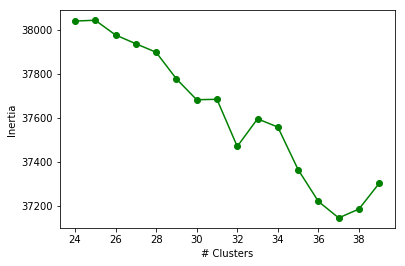

In [63]:
%pylab inline
plt.plot(x, y_inertia, 'go-', )
plt.xlabel('# Clusters')
plt.ylabel('Inertia')

In [33]:
n_topics = 37

**Now let's transform our documents to topic-space**

In [34]:
from sklearn.decomposition import NMF

model = NMF(n_components=n_topics, init='random', random_state=818, alpha = 0.5)
doc_top = model.fit_transform(counts)a

In [35]:
# now let's transform our documents to topic-space
print(f"shape before transforming to topic space: {counts.shape}")
doc_topics = model.transform(counts)
print(f"shape after transforming to topic space: {doc_topics.shape}")

shape before transforming to topic space: (41538, 7385)
shape after transforming to topic space: (41538, 37)


**Show the first 20 words of each topic and I will try to give them a name**

In [36]:
doc_max_top = np.argmax(doc_topics, axis=1)
topic_words = []
for r in model.components_:
    r_normalized = r/sum(r)
    a = sorted([(v,i) for i,v in enumerate(r_normalized)],reverse=True)[0:20]
    topic_words.append([ f"{feature_names[e[1]]}, {e[0]:.2%}"  for e in a])
pd.DataFrame(np.array(topic_words).T)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,"textile, 3.68%","bread, 6.19%","wilton, 5.97%","red man, 5.54%","green, 2.86%","card, 4.45%","postcard, 5.54%","baking, 5.23%","leaves, 2.65%","baseball, 3.70%",...,"york, 1.45%","plate, 10.69%","ostracon, 2.53%","column, 5.29%","dress, 1.64%","shabelsky, 2.32%","ornamented, 4.20%","mail, 5.18%","ornament, 6.47%","gold, 2.55%"
1,"dark reddish, 3.16%","bakery, 5.18%","wilton album, 5.84%","league, 5.01%","blue, 2.42%","trade card, 4.45%","arcade, 4.77%","baking company, 5.18%","flowers, 1.37%","white, 3.11%",...,"city, 0.76%","unnumbered, 2.97%","ostraca, 2.48%","columns, 2.37%","women, 0.76%","russian, 2.04%","isabella, 3.80%","stamps mail, 2.73%","martin, 3.34%","jewelry, 2.36%"
2,"reddish brown, 3.14%","album, 4.23%","information wilton, 5.59%","man, 4.50%","colored, 2.32%","card number, 3.46%","postcard card, 4.76%","company, 4.66%","ornamental, 1.17%","blank, 2.58%",...,"american, 0.67%","unnumbered plate, 2.26%","hieratic, 1.72%","leaves, 2.27%","fashion, 0.68%","garments, 1.35%","parasole italian, 3.75%","mail carriers, 2.73%","augsburg, 3.32%","stones, 1.37%"
3,"reddish, 3.12%","bakery card, 4.16%","album entry, 5.59%","tobacco, 4.32%","white, 1.77%","tea company, 3.19%","machines, 4.71%","kelley, 3.10%","stylized, 1.16%","cards, 2.24%",...,"war, 0.59%","plate plate, 1.90%","ink, 1.46%","italian, 1.86%","woman, 0.66%","russia, 1.07%","isabella catanea, 3.75%","carriers nations, 2.73%","engelbrecht, 3.24%","glass, 1.13%"
4,"brown, 2.94%","bread album, 4.15%","entry, 5.44%","red, 4.04%","purple, 1.42%","pacific tea, 3.19%","arcade machines, 4.54%","collector card, 2.85%","industrie, 1.13%","players, 2.20%",...,"sitter, 0.52%","description, 1.84%","script, 1.36%","italian venice, 1.84%","skirt, 0.66%","woven, 0.98%","catanea parasole, 3.75%","carriers, 2.71%","publisher martin, 3.23%","enamel, 1.11%"
5,"light, 2.75%","loaves, 3.29%","information, 5.38%","chewing, 3.91%","yellow, 1.33%","number flags, 3.19%","chicago, 3.82%","weber, 2.83%","fleurs, 1.12%","bagger, 1.80%",...,"london, 0.49%","plate unnumbered, 1.67%","ink red, 1.26%","matteo, 1.71%","fabric, 0.62%","st, 0.93%","catanea, 3.75%","stamps, 2.69%","prominent augsburg, 3.23%","pearls, 0.83%"
6,"dark, 2.69%","card, 3.01%","album, 4.98%","chewing tobacco, 3.81%","red, 1.29%","modern daylight, 3.19%","card, 3.53%","album, 2.79%","guide du, 1.12%","baseball players, 1.76%",...,"family, 0.48%","plates, 1.58%","cursive, 1.25%","curving, 1.68%","worn, 0.61%","st petersburg, 0.92%","parasole, 3.73%","gibson, 2.64%","ornament fund, 3.23%","diamonds, 0.80%"
7,"pearls, 2.68%","cards loaves, 2.48%","folio, 4.89%","man chewing, 3.67%","leaves, 1.23%","flags modern, 3.19%","company chicago, 3.37%","weber baking, 2.79%","du dessinateur, 1.12%","player, 1.72%",...,"philadelphia, 0.39%","foreground, 1.41%","reed pen, 1.24%","vines, 1.58%","wears, 0.59%","petersburg, 0.91%","squares, 3.32%","crispy, 2.64%","martin engelbrecht, 3.23%","precious, 0.69%"
8,"textile mulhouse, 2.25%","company cards, 2.01%","folio information, 3.64%","player trade, 3.33%","ground, 1.19%","daylight bakery, 3.19%","toned, 3.35%","collector, 2.72%","dessinateur industrie, 1.12%","white blank, 1.61%",...,"york city, 0.39%","temple, 1.36%","chips limestone, 1.24%","lloyd, 1.56%","costume, 0.56%","peasant, 0.90%","rome, 3.24%","collins, 2.60%","fund prominent, 3.23%","frame, 0.66%"
9,"textile haut, 2.25%","gordon, 1.98%","bartsch, 2.44%","league player, 3.33%","black, 1.14%","bakery atlantic, 3.19%","cards company, 3.05%","card, 2.52%","dessinateur, 1.12%","card, 1.60%",...,"glass, 0.38%","description plate, 1.35%","term extension, 1.24%","venice, 1.55%","sleeves, 0.55%","peasant class, 0.90%","italian, 2.78%","goods collins, 2.60%","augsburg publisher, 3.23%","metal, 0.63%"


In [80]:
'god' in feature_names

True

In [81]:
c = 0
for d in met_df['descripcion'] :
    if 'saint' in d :
        #print(d)
        c+=1
        #break
100*c/total

0.9557513602002985

## Plot! (Dimention reduction to 2 (2D))

In [37]:
from sklearn.manifold import TSNE
# plot with tsne!

doc_plot = TSNE(n_components=2,verbose=1, metric="cosine").fit_transform(doc_topics[::n_topics,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1123 samples in 0.000s...
[t-SNE] Computed neighbors for 1123 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1123
[t-SNE] Computed conditional probabilities for sample 1123 / 1123
[t-SNE] Mean sigma: 0.172434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.608284
[t-SNE] Error after 1000 iterations: 0.812123


In [38]:
topics = list(range(1,38))

Populating the interactive namespace from numpy and matplotlib


/Users/monita/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


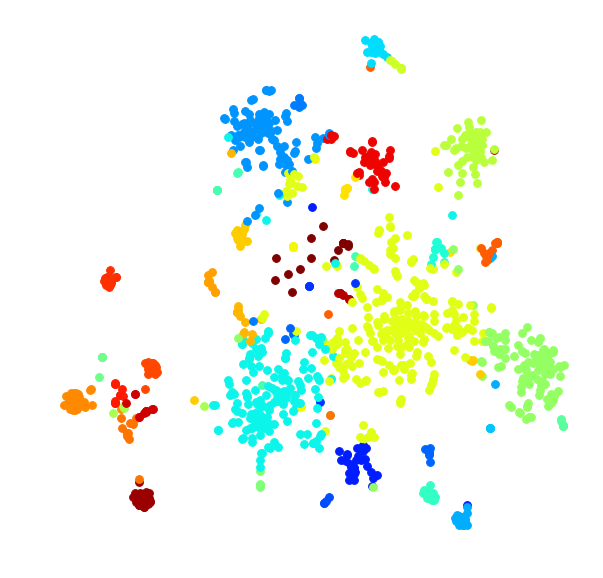

In [39]:
%pylab inline
import matplotlib.patches as mpatches
# plot with tsne!

x = []
y = []
labels = []
tokens=doc_top[::n_topics,:]
for value in doc_plot:
    x.append(value[0])
    y.append(value[1])

cmap = matplotlib.cm.get_cmap('jet_r')
cmapScale = int(cmap.N / n_topics)
plt.figure(figsize=(10, 10),facecolor='white')
labels = [] 
for i in range(len(x)):
    label = np.argmax(tokens[i])
    labels.append(label)
    plt.scatter(x[i],y[i], c=cmap(label*cmapScale),s=60)

# color_legend = []
# for i in range(n_topics):
#     boolArr = np.array(labels) == i
#     x_avg = np.median(np.array(x)[boolArr])
#     y_avg = np.median(np.array(y)[boolArr])
#     plt.annotate(topics[i],
#                  xy=(x_avg, y_avg),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='center',
#                  va='center',
#                  fontsize=15, weight='bold')
#                  #bbox=dict(boxstyle="round", fc="whitesmoke",alpha=0.7))
#     color_legend.append(mpatches.Patch(color=cmap(i*cmapScale), label=f'Topic #{i+1}: {topics[i]}'))
# plt.legend(handles=color_legend,fontsize=18)
plt.axis('off')
plt.show()
plt.savefig("../img/Met_NMF37.pdf")

**TSNE genera distintos plots cada vez, probar varios y guardarlos en pdf**

Populating the interactive namespace from numpy and matplotlib


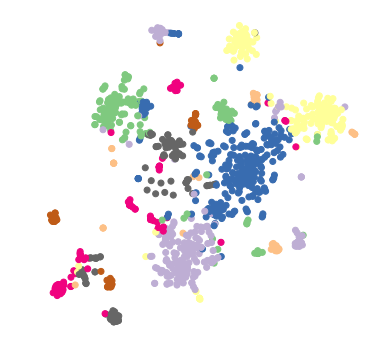

In [29]:
%pylab inline
plt.figure(figsize=(6, 6))
plt.axis('off')
cmap=plt.cm.get_cmap('Accent_r', 20)
plt.scatter(doc_plot[:,0],doc_plot[:,1], c=doc_max_top[::n_topics], cmap=cmap)
plt.savefig("../img/TSNE_Met_NMF_DF_Full.pdf")

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


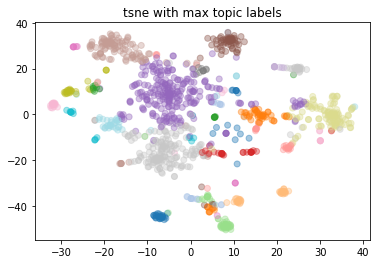

In [83]:
%pylab inline
figure
cmap=plt.cm.get_cmap('tab20', 20)
plt.scatter(doc_plot[:,0],doc_plot[:,1], c=doc_max_top[::n_topics], alpha=.4, cmap=cmap)
plt.title("tsne with max topic labels")
plt.savefig("../img/TSNE_Met_NMF_DF_Full.pdf")

Populating the interactive namespace from numpy and matplotlib


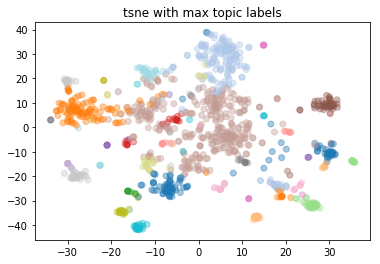

In [71]:
%pylab inline
figure
cmap=plt.cm.get_cmap('tab20', 20)
plt.scatter(doc_plot[:,0],doc_plot[:,1], c=doc_max_top[::n_topics], alpha=.4, cmap=cmap)
plt.title("tsne with max topic labels")
plt.savefig("../img/TSNE_Met_NMF_DF_Full.pdf")

### My Topics. (Analizar y ponerles nombre)

In [48]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: (" % topic_idx
        message += "), (".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message+')')
    print()

In [49]:
print_top_words(model, feature_names, 10)

Topic #0: (textile), (dark reddish), (reddish brown), (reddish), (brown), (light), (dark), (pearls), (mulhouse alsace), (haut)
Topic #1: (bread), (bakery), (album), (bakery card), (bread album), (loaves), (card), (cards loaves), (company cards), (gordon)
Topic #2: (wilton), (wilton album), (album entry), (information wilton), (entry), (information), (album), (folio), (folio information), (bartsch)
Topic #3: (red man), (league), (man), (tobacco), (red), (chewing), (chewing tobacco), (man chewing), (player trade), (league player)
Topic #4: (green), (blue), (colored), (white), (purple), (yellow), (red), (leaves), (ground), (black)
Topic #5: (card), (trade card), (card number), (bakery atlantic), (tea company), (flags modern), (modern daylight), (daylight bakery), (number flags), (pacific tea)
Topic #6: (postcard), (arcade), (postcard card), (machines), (arcade machines), (chicago), (card), (company chicago), (toned), (cards company)
Topic #7: (baking), (baking company), (company), (kelley

In [99]:
#Ver los primeros documentos de UN topic
topic = 27
for doc_i in np.argsort(doc_topics[:,topic])[-3:]:
    print(met_df['descripcion'][doc_i])
    print("-"*80)

This may be the Joseph Griffiths who was a mariner and merchant in New York City, and later the chairman of the Republican Party in New York in 1796. He was married twice, first to Sarah Leonard, on July 19, 1775, and then to Agness Van Wagenen, on April 11, 1781, in New York City.
--------------------------------------------------------------------------------
Rudolphus Bogert (1766-1842) lived in New York City.
--------------------------------------------------------------------------------
The sitter (1822-1913) was the daughter of William Bedlow Crosby and Harriet Ashton Clarkson of New York City.
--------------------------------------------------------------------------------


In [33]:
#Probabilidad de que cada documento sea de un topic
pd.DataFrame(doc_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.009001,0.072276,0.011604,0.000000,0.014630,0.019458,0.000843,0.000000,0.000000,0.000000,0.009671,0.014052,0.000620,0.015221,0.000000e+00,0.000000,0.046067,0.000000,0.006187
1,0.000980,0.080191,0.000000,0.000680,0.000000,0.000955,0.000000,0.000000,0.000000,0.000000,0.002277,0.024415,0.000000,0.000000,1.557454e-02,0.000675,0.003318,0.000000,0.003061
2,0.000000,0.054941,0.000000,0.000000,0.054181,0.000523,0.000000,0.000000,0.000000,0.018112,0.001174,0.015125,0.000000,0.000000,0.000000e+00,0.000656,0.001098,0.000000,0.000000
3,0.000000,0.039850,0.000000,0.000382,0.020922,0.001097,0.000000,0.000000,0.014929,0.000000,0.000000,0.000000,0.000000,0.000000,2.008159e-03,0.000501,0.008109,0.000000,0.000000
4,0.000000,0.044171,0.000000,0.000000,0.000000,0.013482,0.000000,0.000000,0.002783,0.000000,0.000000,0.000000,0.000300,0.000000,2.216490e-07,0.000321,0.000000,0.003913,0.000000
5,0.002533,0.053479,0.000000,0.000000,0.002807,0.000457,0.000000,0.000000,0.028834,0.000000,0.000000,0.000826,0.000282,0.000000,1.553976e-02,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.035555,0.044522,0.000000,0.003435,0.003459,0.000000,0.000000,0.000000,0.000000,0.000211,0.023196,0.000000,0.000000,0.000000e+00,0.000485,0.017229,0.008060,0.000000
7,0.000452,0.124392,0.000000,0.000000,0.000000,0.000845,0.000000,0.000000,0.000000,0.000000,0.000000,0.009340,0.000000,0.000000,0.000000e+00,0.000000,0.022041,0.000000,0.005035
8,0.000000,0.027980,0.000000,0.005029,0.054813,0.000000,0.000000,0.000000,0.000000,0.038029,0.000243,0.009713,0.000000,0.015864,0.000000e+00,0.001500,0.000000,0.000000,0.000000
9,0.000000,0.037337,0.000000,0.000000,0.017680,0.002042,0.000000,0.000000,0.000000,0.000000,0.001379,0.015991,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.006083,0.000000


**Unir las probabilidades a los atributos originales de cada obra y guardarlos en un csv**

In [100]:
full_df = pd.merge(met_df, pd.DataFrame(doc_topics), left_index=True, right_index=True)
full_df

,index,link,descripcion,ent,0,1,2,3,4,5,...,27,28,29,30,31,32,33,34,35,36
0,0,http://www.metmuseum.org/art/collection/search...,"Until the mid-1870s, furniture styles in Ameri...",None,0.002041,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054673,0.000000,0.000000,0.001729,0.008726,0.004717,0.001115,0.000000,0.015141,0.006391
1,1,http://www.metmuseum.org/art/collection/search...,"This cabinet was a gift of its maker, Charles ...",None,0.000000,0.000000,0.001489,0.002516,0.000000,0.000000,...,0.049165,0.000000,0.000000,0.006394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,http://www.metmuseum.org/art/collection/search...,With the development of new formulas and techn...,None,0.000000,0.000000,0.000000,0.000000,0.000554,0.001737,...,0.051425,0.000000,0.000000,0.000000,0.000000,0.001661,0.000000,0.006275,0.000129,0.026792
3,5,http://www.metmuseum.org/art/collection/search...,"This centerpiece, consisting of a double cande...",None,0.000000,0.000000,0.000000,0.000000,0.003063,0.000000,...,0.016856,0.000000,0.000000,0.000957,0.000000,0.000000,0.000000,0.000000,0.005682,0.010784
4,6,http://www.metmuseum.org/art/collection/search...,"Although several similar stands exist, this ex...",None,0.000206,0.002964,0.000000,0.000000,0.000354,0.000000,...,0.009777,0.000000,0.000000,0.000000,0.006507,0.000000,0.000000,0.000000,0.000000,0.000000
5,7,http://www.metmuseum.org/art/collection/search...,Certain features of this stand are peculiar to...,None,0.000533,0.000000,0.000000,0.000000,0.005379,0.000000,...,0.015120,0.000000,0.000000,0.010254,0.001322,0.000000,0.000000,0.000000,0.001368,0.002173
6,9,http://www.metmuseum.org/art/collection/search...,These richly ornamented candlesticks and the a...,None,0.000000,0.000000,0.000000,0.003547,0.000000,0.000000,...,0.035988,0.000000,0.000000,0.000000,0.000000,0.000000,0.026818,0.000000,0.000000,0.002044
7,10,http://www.metmuseum.org/art/collection/search...,In one of Saint-Gaudens’s earliest representat...,None,0.000000,0.000000,0.000000,0.000466,0.000000,0.000000,...,0.012044,0.000000,0.000000,0.000000,0.002791,0.000000,0.000000,0.000000,0.000000,0.000000
8,11,http://www.metmuseum.org/art/collection/search...,"This candlestick, whose design was patented in...",None,0.000000,0.000000,0.000000,0.000000,0.000125,0.006507,...,0.028950,0.002774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000536,0.027685
9,12,http://www.metmuseum.org/art/collection/search...,A typical household in seventeenth-century New...,None,0.000000,0.000286,0.000000,0.000000,0.000000,0.000000,...,0.008823,0.000000,0.000000,0.000000,0.000000,0.011008,0.000000,0.000251,0.000000,0.008778


In [101]:
model.feature_names = feature_names
with open('../models/Met_NMF37_a5.pkl', 'wb') as f:
    pickle.dump(full_df, f)